<a href="https://colab.research.google.com/github/hbisgin/DeepLearning/blob/main/DL_9_Q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import *
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time


<Axes: >

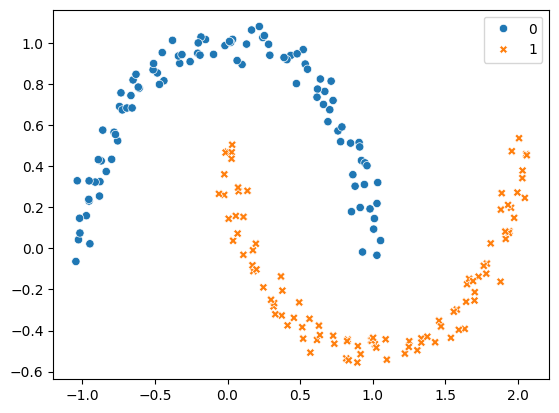

In [53]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y)

In [54]:
classification_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
training_loader = DataLoader(classification_dataset)

In [23]:
in_features = 2
out_features = 2
model = nn.Linear(in_features, out_features)

In [32]:
def train_simple_network(model, loss_func, training_loader, epochs=20, device="cpu"):
    #Yellow step is done here. We create the optimizer and move the model to the compute device
    #SGD is Stochastic Gradient Decent over the parameters $\Theta$
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    #The next two for loops handle the Red steps, iterating through all the data (batches) multiple times (epochs)
    for epoch in tqdm(range(epochs), desc="Epoch"):

        model = model.train()#Put our model in training mode
        running_loss = 0.0

        for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):
            #Move the batch of data to the device we are using. this is the last red step
            inputs = inputs.to(device)
            labels = labels.to(device)

            #First a yellow step, prepare the optimizer. Most PyTorch code will do this first to make sure everything is in a clean and ready state.

            #PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it.
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            #The next two lines of code perform the two blue steps
            y_hat = model(inputs) #this just computed $f_\theta(\boldsymbol{x_i})

            # Compute loss.
            loss = loss_func(y_hat, labels)

            #Now the remaining two yellow steps, compute the gradient and ".step()" the optimizer
            loss.backward()# $\nabla_\Theta$ just got computed by this one call

            #Now we just need to update all the parameters
            optimizer.step()# $\Theta_{k+1} = \Theta_k − \eta \cdot \nabla_\Theta \ell(\hat{y}, y)$

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item()
        if epoch==1:
          print(y_hat, nn.functional.softmax(y_hat, dim=1))
          break

In [33]:
loss_func = nn.CrossEntropyLoss()
train_simple_network(model, loss_func, training_loader, epochs=50)

Epoch:   2%|▏         | 1/50 [00:02<01:38,  2.01s/it]

tensor([[-0.5568,  0.3800]], grad_fn=<AddmmBackward0>) tensor([[0.2815, 0.7185]], grad_fn=<SoftmaxBackward0>)


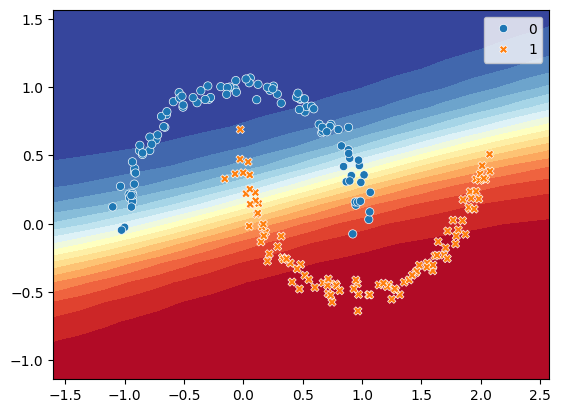

In [34]:
def visualize2DSoftmax(X, y, model, title=None):
    x_min = np.min(X[:,0])-0.5
    x_max = np.max(X[:,0])+0.5
    y_min = np.min(X[:,1])-0.5
    y_max = np.max(X[:,1])+0.5
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20), np.linspace(y_min, y_max, num=20), indexing='ij')
    xy_v = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1)))
    with torch.no_grad():
        logits = model(torch.tensor(xy_v, dtype=torch.float32))
        y_hat = F.softmax(logits, dim=1).numpy()

    cs = plt.contourf(xv, yv, y_hat[:,0].reshape(20,20), levels=np.linspace(0,1,num=20), cmap=plt.cm.RdYlBu)
    ax = plt.gca()
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=ax)
    if title is not None:
        ax.set_title(title)

visualize2DSoftmax(X, y, model)

#Let's change the network architecture a bit

In [35]:
model = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
train_simple_network(model, loss_func, training_loader, epochs=50)

Epoch:   2%|▏         | 1/50 [00:00<00:16,  2.92it/s]

tensor([[-0.1846, -0.0159]], grad_fn=<AddmmBackward0>) tensor([[0.4579, 0.5421]], grad_fn=<SoftmaxBackward0>)


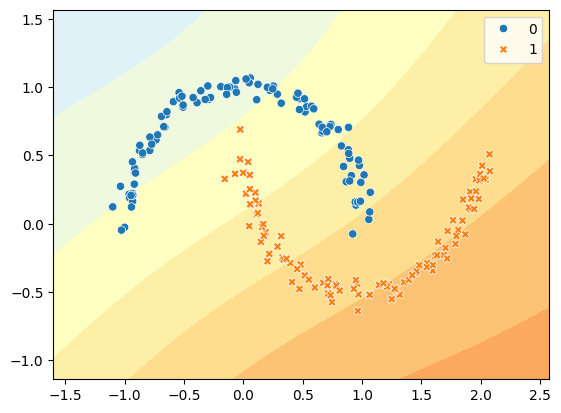

In [36]:
visualize2DSoftmax(X, y, model)

In [56]:
classification_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
training_loader = DataLoader(classification_dataset)

In [74]:
def train_simple_network_bce_logits(model, loss_func, training_loader, epochs=20, device="cpu"):
    #Yellow step is done here. We create the optimizer and move the model to the compute device
    #SGD is Stochastic Gradient Decent over the parameters $\Theta$
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    #The next two for loops handle the Red steps, iterating through all the data (batches) multiple times (epochs)
    for epoch in tqdm(range(epochs), desc="Epoch"):

        model = model.train()#Put our model in training mode
        running_loss = 0.0

        for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):
            #Move the batch of data to the device we are using. this is the last red step
            inputs = inputs.to(device)
            labels = labels.to(device)

            #First a yellow step, prepare the optimizer. Most PyTorch code will do this first to make sure everything is in a clean and ready state.

            #PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it.
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            #The next two lines of code perform the two blue steps
            y_hat = model(inputs) #this just computed $f_\theta(\boldsymbol{x_i})
            print(y_hat.shape, labels.shape)

            # Compute loss.
            loss = loss_func(y_hat.view(-1,1), labels.view(-1,1))

            #Now the remaining two yellow steps, compute the gradient and ".step()" the optimizer
            loss.backward()# $\nabla_\Theta$ just got computed by this one call

            #Now we just need to update all the parameters
            optimizer.step()# $\Theta_{k+1} = \Theta_k − \eta \cdot \nabla_\Theta \ell(\hat{y}, y)$

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item()
        if epoch==1:
          print(y_hat, nn.functional.softmax(y_hat, dim=1))
          break

In [ ]:
model = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 1),
)
loss_func = nn.BCEWithLogitsLoss()
train_simple_network_bce_logits(model, loss_func, training_loader, epochs=50)

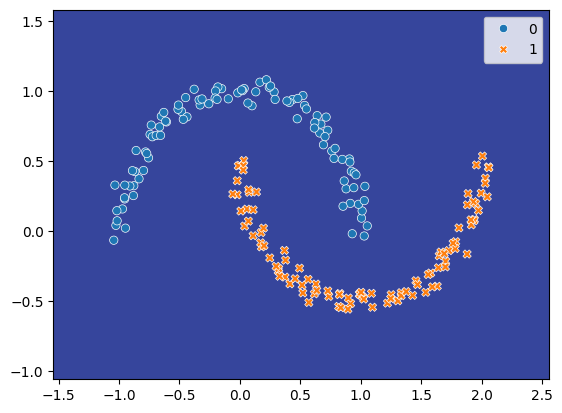

In [64]:
visualize2DSoftmax(X, y, model)

# Using BCELoss

In [72]:
import torch
import torch.nn as nn
from tqdm import tqdm

def train_simple_network_bce(model, loss_func, training_loader, epochs=20, device="cpu"):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    model.to(device)

    for epoch in tqdm(range(epochs), desc="Epoch"):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):
            inputs = inputs.to(device)

            # BCELoss needs float targets (0/1) and matching shape
            labels = labels.to(device).view(-1, 1)

            optimizer.zero_grad()

            logits = model(inputs)                  # raw output, shape [B,1] usually
            probs  = torch.sigmoid(logits)          # <-- KEY CHANGE for BCELoss

            loss = loss_func(probs, labels)         # <-- pass probs, not logits

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / max(1, len(training_loader))
        tqdm.write(f"Epoch {epoch+1}/{epochs} - loss: {avg_loss:.4f}")


In [73]:
model = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 1),
)
loss_func = nn.BCELoss()
train_simple_network_bce(model, loss_func, training_loader, epochs=50)

Epoch:   2%|▏         | 1/50 [00:00<00:09,  5.16it/s]

Epoch 1/50 - loss: 0.6770



Epoch:   4%|▍         | 2/50 [00:00<00:09,  5.09it/s]

Epoch 2/50 - loss: 0.6419



Epoch:   6%|▌         | 3/50 [00:00<00:09,  5.18it/s]

Epoch 3/50 - loss: 0.6098



Epoch:   8%|▊         | 4/50 [00:00<00:08,  5.22it/s]

Epoch 4/50 - loss: 0.5797



Epoch:  10%|█         | 5/50 [00:00<00:08,  5.18it/s]

Epoch 5/50 - loss: 0.5513



Epoch:  12%|█▏        | 6/50 [00:01<00:08,  5.23it/s]

Epoch 6/50 - loss: 0.5245



Epoch:  14%|█▍        | 7/50 [00:01<00:08,  5.07it/s]

Epoch 7/50 - loss: 0.4995



Epoch:  16%|█▌        | 8/50 [00:01<00:08,  5.14it/s]

Epoch 8/50 - loss: 0.4765



Epoch:  18%|█▊        | 9/50 [00:01<00:07,  5.24it/s]

Epoch 9/50 - loss: 0.4556



Epoch:  20%|██        | 10/50 [00:01<00:08,  4.68it/s]

Epoch 10/50 - loss: 0.4368



Epoch:  22%|██▏       | 11/50 [00:02<00:08,  4.44it/s]

Epoch 11/50 - loss: 0.4202



Epoch:  24%|██▍       | 12/50 [00:02<00:08,  4.25it/s]

Epoch 12/50 - loss: 0.4055



Epoch:  26%|██▌       | 13/50 [00:02<00:08,  4.22it/s]

Epoch 13/50 - loss: 0.3927



Epoch:  28%|██▊       | 14/50 [00:02<00:08,  4.24it/s]

Epoch 14/50 - loss: 0.3816



Epoch:  28%|██▊       | 14/50 [00:03<00:07,  4.51it/s]


KeyboardInterrupt: 

#Can you try one of the network desings and training functions to predict the species of iris flowers? Please feel free to use your earlier notebooks for dataloader generation if needed.

In [ ]:
#you can use this code block for your experiments

#A little bit more training style

In [48]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using.
        inputs = inputs.to(device)
        labels = labels.to(device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()

    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem

    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

# new definition for train network

In [49]:
def train_simple_network2(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=50, device="cpu", checkpoint_file=None):
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# set up everything again

In [43]:
X_train, y_train = make_moons(n_samples=8000, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
training_loader = DataLoader(train_dataset, shuffle=True)
testing_loader = DataLoader(test_dataset)

In [50]:
model = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
results_pd = train_simple_network2(model, loss_func, training_loader, epochs=5, test_loader=testing_loader, checkpoint_file='model.pt', score_funcs={'Acc':accuracy_score,'F1': f1_score})

Training:  99%|█████████▉| 7932/8000 [00:08<00:00, 1193.70it/s]
                                                               
Training: 100%|█████████▉| 7987/8000 [00:07<00:00, 1189.80it/s]
                                                               
Epoch:  40%|████      | 2/5 [00:21<00:31, 10.58s/it]


KeyboardInterrupt: 